<br><h1> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="120" width="400" align="Center" /><br>

# MIIIA Advanced Models: Project 2 - 29 Jun 2020

                     Names                 User        Code
           - Alexander Camargo García   a.camargo733   200911325
           - Jaime Orjuela Viracachá    j.orjuelav     201924252
           - Jairo Pedraza Corredor     ja.pedraza     201924260
           - Elquin Huertas Ramírez     e.huertas      201920061

# Project 2

# Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

# Exercise P2.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process. 


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from random import randrange

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
data = pd.read_csv('dataTrain_carListings.zip')

In [7]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [8]:
data.shape

(500000, 6)

#### Verificación de datos faltantes

In [9]:
data.isna().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [10]:
data["unos"]=1
print(data.dtypes)

Price       int64
Year        int64
Mileage     int64
State      object
Make       object
Model      object
unos        int64
dtype: object


#### Análisis exploratorio variables independientes

- **State variable**:

In [11]:
# El mismo estado puede aparecer con combinaciones de minúsculas y mayúsculas así que se pasa a mayúscula sostenida
data["State"] = data["State"].str.upper()

- **Year variable**:

In [10]:
data.Year.describe(percentiles=[0.05, 0.1, 0.15, 0., .25, .5, .75, 0.9, 0.95])

count   500,000.00
mean      2,013.20
std           3.29
min       1,997.00
0%        1,997.00
5%        2,006.00
10%       2,008.00
15%       2,010.00
25%       2,012.00
50%       2,014.00
75%       2,016.00
90%       2,017.00
95%       2,017.00
max       2,018.00
Name: Year, dtype: float64

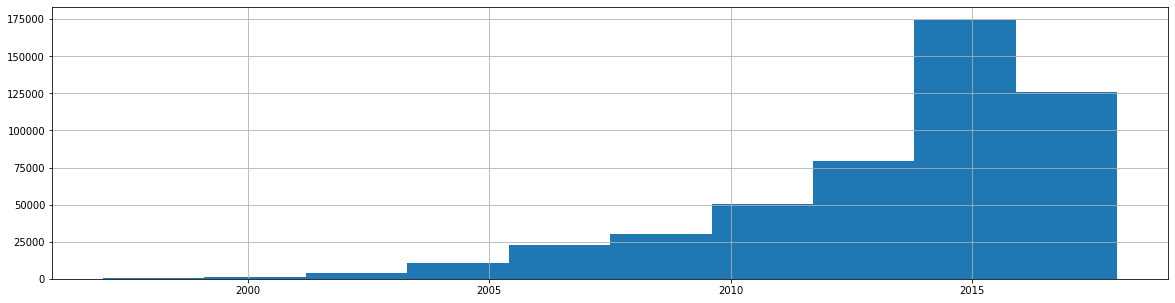

In [11]:
plt.figure(figsize=(20,5))
data["Year"].hist()

*Se observa una alta concentración en automóviles recientes, el promedio está en 2013, sin embargo el primer decil de los datos se encuentra en el año 2008 de la variable Year* 

*Este comportamiento sugiere analizar la variable para identificar la existencia de datos atípicos mediante un* **boxplot**

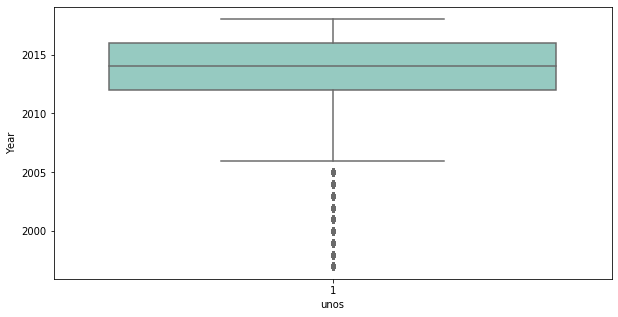

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x="unos", y="Year",  data=data, palette="Set3")

- *Efectivamente, se observan valores extremos en la distribución de los datos, el análisis muestra que estos se presentan 
en la parte inferior de la distribución, antes del año 2006 aproximadamente.*

- *Para ver la relación de estos valores extremos con el precio de los vehículos, se debe hacer un gráfico de puntos de estas dos variables.*


- **Mileage variable**:

In [13]:
data.Mileage.describe(percentiles=[0.05, 0.1, 0.15, 0., .25, .5, .75, 0.9, 0.95, 0.97, 0.98, 0.99,  0.995, 0.99995])

count       500,000.00
mean         55,076.43
std          40,897.04
min               5.00
0%                5.00
5%            8,599.00
10%          14,411.00
15%          18,691.00
25%          25,855.00
50%          42,990.00
75%          77,406.00
90%         111,269.00
95%         133,220.15
97%         148,716.09
98%         160,397.04
99%         180,459.11
99.5%       200,105.01
99.995%     547,050.70
max       2,457,832.00
Name: Mileage, dtype: float64

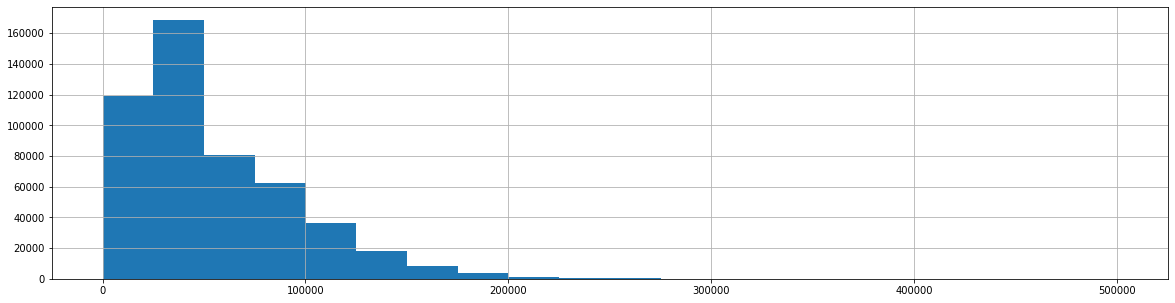

In [14]:
plt.figure(figsize=(20,5))
data["Mileage"].hist(bins=20,range=(5,500200))

*Se observa una alta concentración de automóviles con bajo kilometraje, el promedio está en 55.000 y la mediana en 43.000; esto indica que hay presencia de datos extremos o atípicos que aumentan el valor del promedio respecto de la mediana de la variable* **Mileage** 

*Este comportamiento sugiere analizar la variable para identificar la existencia de datos atípicos mediante un* **boxplot**

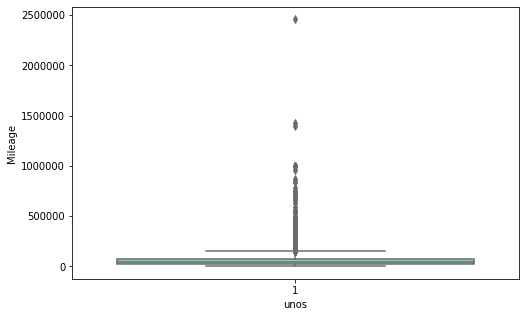

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x="unos", y="Mileage",  data=data, palette="Set3")

- *Efectivamente como se anunció antes, se observan datos atípicos a partir del valor 200.000 aproximadamente, dado el alto volumen de datos para entrenar un modelo es posible pensar en no considerar estos valores, sin embargo se deben hacer otros análisis*.
- *Otra opción, luego de analizar la relación de los datos atípicos encontrados con las demás variables, para el proceso de modelado conviene utilizar el logaritmo o reescalar*

*Adicionante revisemos la relación que tienen los años más antiguos de los automóviles con el kilometraje de los mismos.*

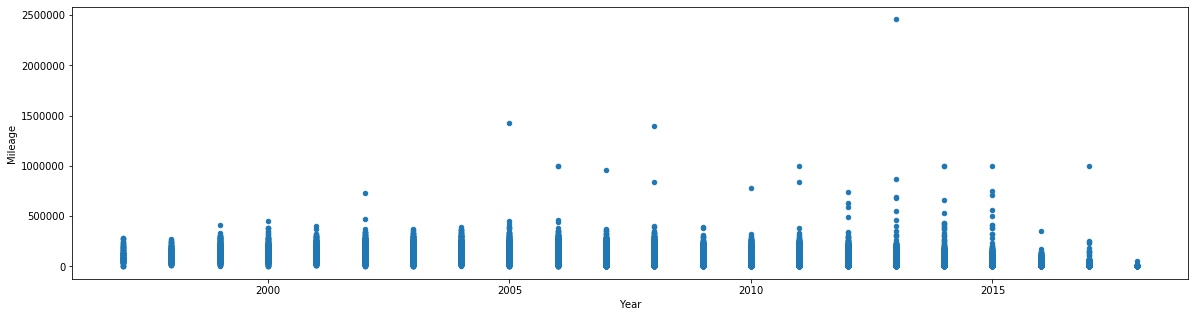

In [16]:
data.plot(kind='scatter', y='Mileage', x='Year',figsize=(20,5))

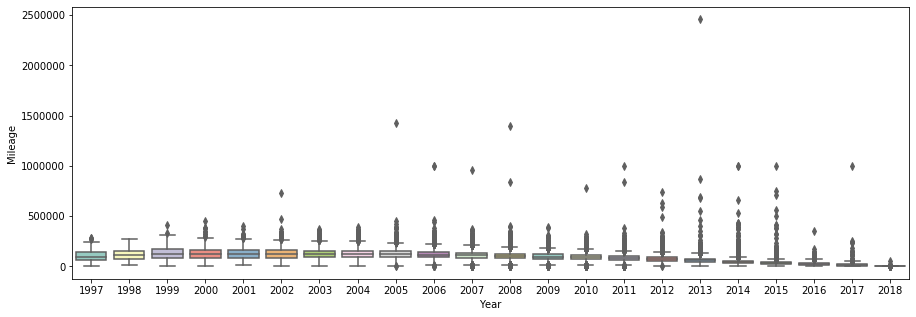

In [17]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Year", y="Mileage",  data=data, palette="Set3")

- *De acuerdo con estos análisis gráficos, se observa que los datos atípicos de la variable* **Mileage** están distribuidos en varios años del modelo que les corresponde a los automóviles bajo estudio.
- En cuanto a los automóviles más antiguos, no se nota una asociación de los datos atípicos encontrados de la variable* **Mileage** . 
- *Dado este resultado, conviene excluir al 0.5% de la muestra que representan los datos atípicos de la variable* **Mileage.**

###### Procedimiento para remover del análisis las observaciones atípicas de la variable Mileage .

In [18]:
data2=data[data.Mileage<=200000]
data2.head()

,Price,Year,Mileage,State,Make,Model,unos
0,21490,2014,31909,MD,Nissan,MuranoAWD,1
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe,1
2,20925,2016,24633,SC,Hyundai,Santa,1
3,14500,2012,84026,OK,Jeep,Grand,1
4,32488,2013,22816,TN,Jeep,Wrangler,1


- *Veámos cómo queda la distribución al excluir los datos atípicos identificados

In [19]:
data2.Mileage.describe(percentiles=[0.05, 0.1, 0.15, 0., .25, .5, .75, 0.9, 0.95, 0.97, 0.98, 0.99,  0.999, 0.99995])

count     497,488.00
mean       54,130.93
std        38,258.43
min             5.00
0%              5.00
5%          8,563.00
10%        14,359.00
15%        18,632.00
25%        25,760.75
50%        42,790.00
75%        76,700.00
90%       109,873.00
95%       130,473.90
97%       144,303.95
98%       154,215.78
99%       169,002.04
99.9%     195,156.59
99.995%   199,925.38
max       200,000.00
Name: Mileage, dtype: float64

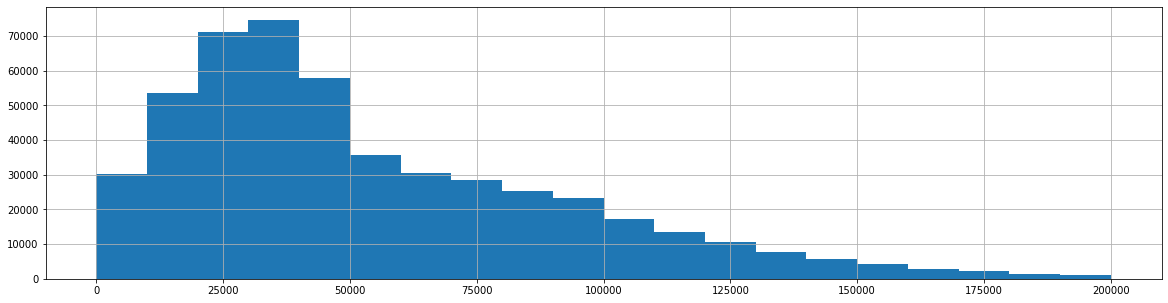

In [20]:
plt.figure(figsize=(20,5))
data2["Mileage"].hist(bins=20)

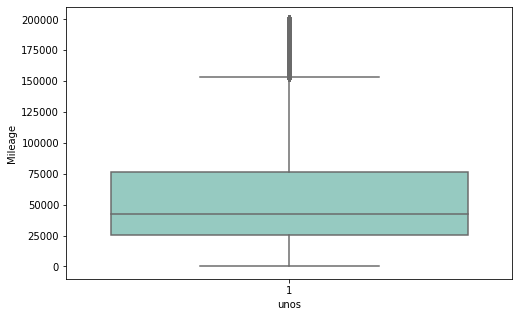

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(x="unos", y="Mileage",  data=data2, palette="Set3")

- *La distribución se ve menos sesgada hacia la derecha; no obstante hay presencia de datos extremos por lo que se recomienda  para el proceso de modelado  utilizar el logaritmo de los valores de esta variable*

In [22]:
data2["LogMileage"] = np.log(data2["Mileage"])
data2.head(10)
data2.LogMileage.describe(percentiles=[0.05, 0.1, 0.15, 0., .25, .5, .75, 0.9, 0.95, 0.97, 0.98, 0.99,  0.999, 0.99995])

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count     497,488.00
mean           10.59
std             0.97
min             1.61
0%              1.61
5%              9.06
10%             9.57
15%             9.83
25%            10.16
50%            10.66
75%            11.25
90%            11.61
95%            11.78
97%            11.88
98%            11.95
99%            12.04
99.9%          12.18
99.995%        12.21
max            12.21
Name: LogMileage, dtype: float64

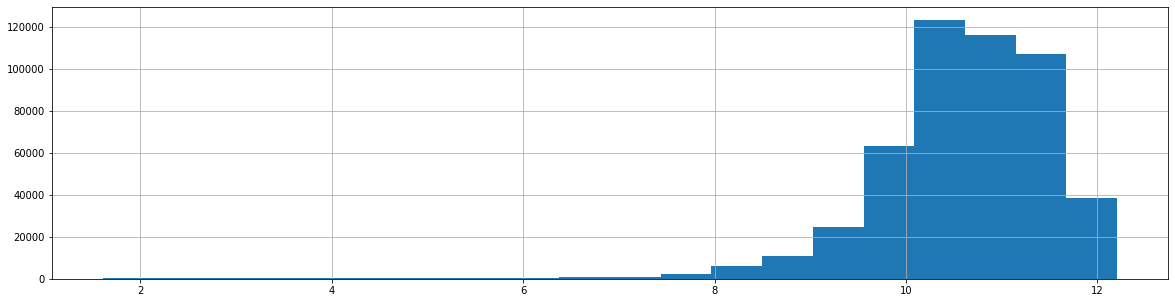

In [23]:
plt.figure(figsize=(20,5))
data2["LogMileage"].hist(bins=20)

#### Variable Price

In [24]:
data2.Price.describe(percentiles=[0.05, 0.1, 0.15, 0., .25, .5, .75, 0.9, 0.95, 0.97, 0.98, 0.99,  0.999, 0.99995])

count     497,488.00
mean       21,196.50
std        10,748.66
min         5,001.00
0%          5,001.00
5%          7,988.00
10%         9,855.70
15%        10,999.00
25%        13,526.00
50%        18,495.00
75%        26,999.00
90%        35,809.30
95%        41,992.00
97%        46,588.00
98%        49,900.00
99%        54,991.00
99.9%      71,900.00
99.995%    79,991.00
max        79,999.00
Name: Price, dtype: float64

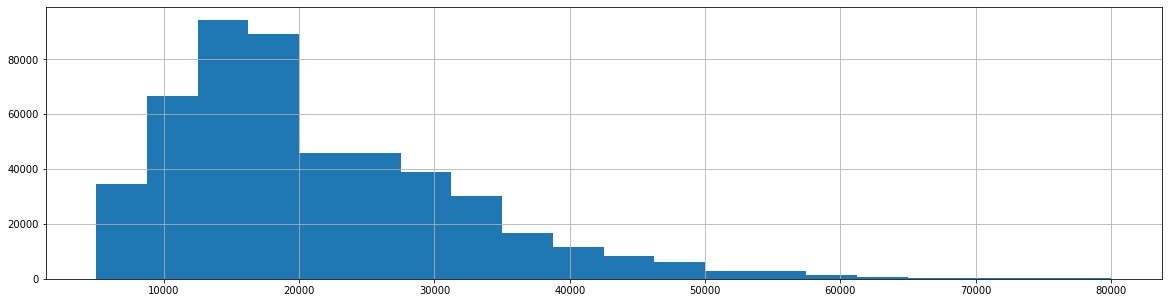

In [25]:
plt.figure(figsize=(20,5))
data2["Price"].hist(bins=20)

*Esta variable presente asimetría en el lado derecho de la distribución, generando con esto que el promedio se vea afectado por la presencia de valores extremos.*

*Analicemos el comportamiento de la variable mediante un* **boxplot**

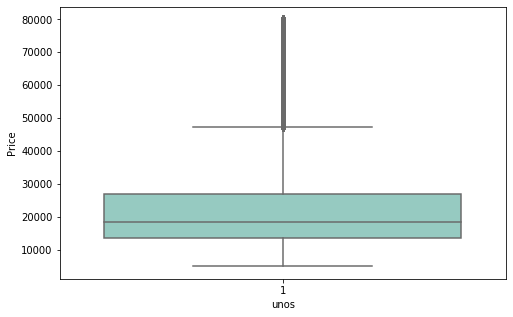

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x="unos", y="Price",  data=data, palette="Set3")

- *Se observan datos extremos a partir de del valor 50.000 aproximadamente*.
- *Se recomienda trabajar transformando la variable usando el logaritmo*. 

In [27]:
data2["LogPrice"] = np.log(data2["Price"])
data2.head(10)
data2.LogPrice.describe(percentiles=[0.05, 0.1, 0.15, 0.2, .25, .5, .75, 0.9, 0.95, 0.97, 0.98, 0.99,  0.999, 0.99995])

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count     497,488.00
mean            9.84
std             0.50
min             8.52
5%              8.99
10%             9.20
15%             9.31
20%             9.43
25%             9.51
50%             9.83
75%            10.20
90%            10.49
95%            10.65
97%            10.75
98%            10.82
99%            10.91
99.9%          11.18
99.995%        11.29
max            11.29
Name: LogPrice, dtype: float64

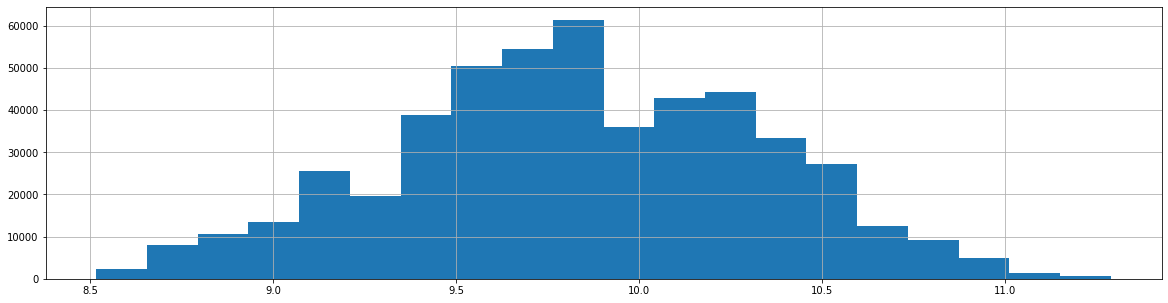

In [28]:
plt.figure(figsize=(20,5))
data2["LogPrice"].hist(bins=20)

- *Al aplicar la transformación, se reduce ampliamente el sesgo que tenía la variable original*

In [29]:
print(data2.dtypes)

Price           int64
Year            int64
Mileage         int64
State          object
Make           object
Model          object
unos            int64
LogMileage    float64
LogPrice      float64
dtype: object


In [30]:
#Se conservan las varibles para el análisis
data2=data2.iloc[:,[8,1,7,3,4,5]]
print(data2.dtypes)

LogPrice      float64
Year            int64
LogMileage    float64
State          object
Make           object
Model          object
dtype: object


- *Evaluemos gráficamente la relación de estos valores con las demás variables cuantitativas.*

#### Scarters Plot: Variables continuas

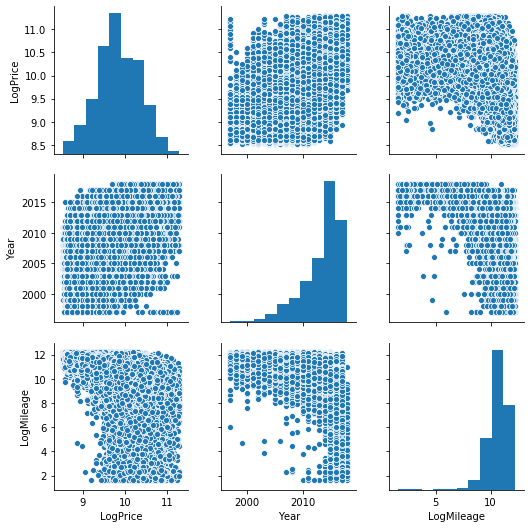

In [31]:
sns.pairplot(data2[["LogPrice","Year", "LogMileage"]])
plt.show()

- *Con base en el gráfico, La variable "Year" tiene cierta relación lineal positiva con la variable LogPrice*. Mostrando que entre más reciente es el auto, mayor es su valor.
- *De igual manera, también se observa tendencia linear negativa de la variable de kilometraje "LogMeliage" con "LogPrice", evidenciando que a mayor valor de kilometraje, menor es el valor del automóvil*.
- *Con base en lo anterior, se analizan los coeficientes de correlación entre las variables cuantitativas*

In [32]:
data2[["LogPrice", "LogMileage","Year"]].corr(method ='pearson').style.format("{:.4}")

,LogPrice,LogMileage,Year
LogPrice,1.0,-0.4818,0.5667
LogMileage,-0.4818,1.0,-0.6156
Year,0.5667,-0.6156,1.0


- *Las dos variables, LogMileage y Year, tienen moderada-alta correlación con el Logarítmo del precio, una es negativa y la otra positiva, respectivamente*

#### Veámos ahora la manera de cómo vamos a trabajar con las variables categóricas de la base de datos

In [110]:
encoder_purpose = ce.HashingEncoder(n_components=7, cols=['State', 'Make', 'Model'])
en_data = encoder_purpose.fit_transform(data2)
en_data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,LogPrice,Year,LogMileage
0,0,0,1,0,1,1,0,9.98,2014,10.37
1,0,0,1,1,1,0,0,9.96,2016,10.16
2,0,0,1,1,0,1,0,9.95,2016,10.11
3,1,0,1,1,0,0,0,9.58,2012,11.34
4,1,1,1,0,0,0,0,10.39,2013,10.04


In [111]:
en_data.to_csv('en_data.csv', index = False)

In [112]:
en_data = pd.read_csv('en_data.csv')

In [36]:
print(en_data['col_0'].value_counts())
print(en_data['col_1'].value_counts())
print(en_data['col_2'].value_counts())
print(en_data['col_3'].value_counts())
print(en_data['col_4'].value_counts())
print(en_data['col_5'].value_counts())
print(en_data['col_6'].value_counts())
en_data.shape

0    298066
1    169320
2     28606
3      1496
Name: col_0, dtype: int64
0    365850
1    115623
2     15242
3       773
Name: col_1, dtype: int64
0    266771
1    188526
2     40038
3      2153
Name: col_2, dtype: int64
0    264118
1    184493
2     44599
3      4278
Name: col_3, dtype: int64
0    317690
1    151502
2     26525
3      1771
Name: col_4, dtype: int64
0    294178
1    157801
2     42327
3      3182
Name: col_5, dtype: int64
0    411949
1     81541
2      3969
3        29
Name: col_6, dtype: int64


(497488, 10)

- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process. 

### Modelamiento de los datos

In [37]:
y = en_data['LogPrice']
X = en_data.drop(['LogPrice'], axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [39]:
X_test.shape

(124372, 9)

- *Modelado de los datos usando RandomForestRegressor*

In [40]:
RegRanForest = RandomForestRegressor(random_state=0, n_jobs=-1)
PredRegRanForest=RegRanForest.fit(X_train, y_train)
predictions = PredRegRanForest.predict(X_test)
print(predictions)
predictions.shape

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[ 9.41393114 10.17651766  9.73127134 ...  9.90931266  9.70902953
 10.3975169 ]


(124372,)

In [41]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_test, predictions)**0.5
print('Test RMSE: %.3f' % error)

Test RMSE: 0.428


- El RMSE del modelo entrenado con Random Forest es 0.428 

#### ¿Ahora si se optimiza el hiperparámetro n_estimators, se mejora el RSME?

In [42]:
estimator_range = range(1, 50, 1)

# list to store the average Accuracy for each value of n_estimators
error_scores = []


for estimator in estimator_range:
    RandForestReg = RandomForestRegressor(n_estimators=estimator, random_state=0, n_jobs=-1)
    predictions = PredRegRanForest.predict(X_test)
    error_scores.append((mean_squared_error(y_test, predictions)**0.5))

Text(0, 0.5, 'RMSE')

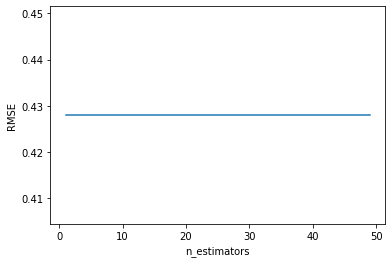

In [43]:
plt.plot(estimator_range, error_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

- Al optimizar el hiperparámetro n_estimators, no hay mejora para el RMSE del modelo entrenado con Random Forest

- *Modelado de los datos usando XGBOOTING Regressor*

In [44]:
import xgboost as xgb

In [128]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
error = mean_squared_error(y_test, preds)**0.5
print('Test RMSE XGBoost: %.5f' % error)

C:\Users\Usuario\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test RMSE XGBoost: 0.37825


- Sin optimizar los hiperparámetros, el XGBootsRegresor optime un menor RMSE que el RandomForest 

### Optimizando Hiperparámetros del XGBoost Regressor

- *n_estimators*

In [46]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [48]:
def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = list(dataset.index.values) 
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [133]:
def cross_val_scores(model, dataframe, k=3):
    train_folds= []
    for i in range(k):  
        a = range(k)
        b = [x for m,x in enumerate(a) if m!=i]
        train_folds.append(b)
    train_data=dataframe.sample(frac=0.90, random_state=1)
    folds = cross_validation_split(train_data, k)
    error_scores = []
    for i in range(k):
        test= folds[i]
        train=[]
        
        for j in range(k-1):
            train.append(folds[train_folds[i][j]])
        flat_list = []
        for sublist in train:
            for item in sublist:
                flat_list.append(item)
        train = flat_list
        #Test y Train
        Train = train_data.loc[train]
        y_train = Train.LogPrice.values
        X_train = Train.drop(columns = 'LogPrice', axis = 1)
        Test = train_data.loc[test]
        y_test = Test.LogPrice.values
        X_test = Test.drop(columns = 'LogPrice', axis = 1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error_scores.append((mean_squared_error(y_test, preds)**0.5))
    return mean(error_scores)

In [143]:
estimator_range = [50, 150, 200, 250]
error_scores = []
for i in estimator_range:
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=i, random_state=0, n_jobs=-1)
    K=10
    solv = cross_val_scores(xg_reg, en_data, K)
    error_scores.append(solv)
    print(i)

50
150
200
250


In [144]:
error_scores

[0.3854930600985835,
 0.37710444854117986,
 0.3759492060420324,
 0.3751546903135558]

Text(0, 0.5, 'RMSE')

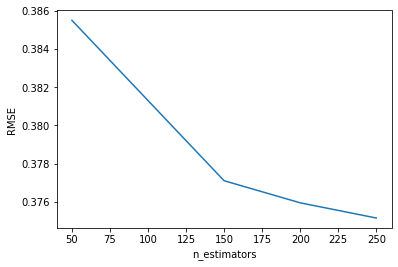

In [145]:
plt.plot(estimator_range, error_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [136]:
colsample_bytree_opts = [0.3, 0.5, 0.8, 1]

# list to store the average Accuracy for each value of n_estimators
error_scores = []

for i in colsample_bytree_opts:
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=i, random_state=0, n_jobs=-1, )
    K=10
    solv = cross_val_scores(xg_reg, en_data, K)
    error_scores.append(solv)
    print(i)

0.3
0.5
0.8
1


In [137]:
error_scores

[0.38305613911733266,
 0.3796468983818514,
 0.37889803270986017,
 0.37878817766584477]

Text(0, 0.5, 'RMSE')

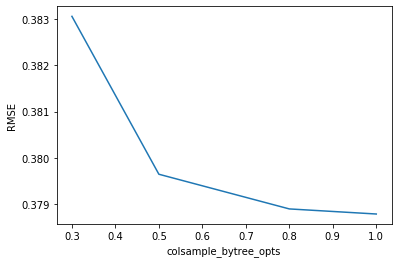

In [138]:
plt.plot(colsample_bytree_opts, error_scores)
plt.xlabel('colsample_bytree_opts')
plt.ylabel('RMSE')

In [139]:
gamma_opts = [1, 3, 5]

# list to store the average Accuracy for each value of n_estimators
error_scores = []

for i in gamma_opts:
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', gamma=i, random_state=0, n_jobs=-1, )
    K=10
    solv = cross_val_scores(xg_reg, en_data, K)
    error_scores.append(solv)
    print(i)

1
3
5


In [140]:
error_scores

[0.3788780943974951, 0.37907750803972384, 0.37964252140482824]

Text(0, 0.5, 'RMSE')

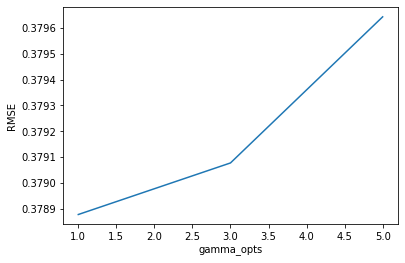

In [141]:
plt.plot(gamma_opts, error_scores)
plt.xlabel('gamma_opts')
plt.ylabel('RMSE')

#### Dadas las optimizaciones individuales de los hiperparámetros, el mejor modelo es el siguiente:

In [115]:
y = en_data['LogPrice']
X = en_data.drop(['LogPrice'], axis=1)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [117]:
X_test.shape

(124372, 9)

In [146]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.8, n_estimators=250, gamma=1, random_state=0, n_jobs=-1, )
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
error = mean_squared_error(y_test, preds)**0.5
print('Test RMSE XGBoost: %.5f' % error)

C:\Users\Usuario\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test RMSE XGBoost: 0.37557


#### De acuerdo con las optimizaciones de los hiperparámetros, el RMSE obtenido es 0.37557

# Exercise P2.2 (50%)

API of the model.

URL:
http://ec2-13-59-195-186.us-east-2.compute.amazonaws.com:5000/

Github:
https://github.com/halepz/Proyecto_2_MAAD
